In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Constants
USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS_MONITORED = 950

# Load monitored data
print("Loading monitored datafile...")
with open("mon_standard.pkl", 'rb') as fi:
    monitored_data = pickle.load(fi)

X1_mon, X2_mon, y_mon = [], [], []
for i in range(TOTAL_URLS_MONITORED):
    label = i // URL_PER_SITE  # Assign site-specific labels
    for sample in monitored_data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1_mon.append(time_seq)
        X2_mon.append(size_seq)
        y_mon.append(label)

# Create DataFrame for monitored data
df_mon = pd.DataFrame({
    'time_seq': X1_mon,
    'size_seq': X2_mon,
    'label': y_mon
})

# Feature Engineering
df_mon['cumulative_size'] = df_mon['size_seq'].apply(np.cumsum)
df_mon['burst_std'] = df_mon['size_seq'].apply(lambda x: np.std(np.diff(x, prepend=0)))
df_mon['mean_packet_size'] = df_mon['size_seq'].apply(np.mean)
df_mon['mean_timestamp'] = df_mon['time_seq'].apply(np.mean)
df_mon['num_incoming'] = df_mon['size_seq'].apply(lambda x: sum(1 for i in x if i < 0))
df_mon['num_outgoing'] = df_mon['size_seq'].apply(lambda x: sum(1 for i in x if i > 0))
df_mon['fraction_incoming'] = df_mon['num_incoming'] / (df_mon['num_incoming'] + df_mon['num_outgoing'])
df_mon['fraction_outgoing'] = df_mon['num_outgoing'] / (df_mon['num_incoming'] + df_mon['num_outgoing'])
df_mon['total_packets'] = df_mon['num_incoming'] + df_mon['num_outgoing']

df_mon['packetsize_std'] = df_mon['size_seq'].apply(lambda x: np.std(x))
df_mon['timestamp_std'] = df_mon['time_seq'].apply(lambda x: np.std(x))

df_mon['mean_outgoing_packets'] = df_mon['size_seq'].apply(lambda x: np.mean([i for i in x if i > 0]) if any(i > 0 for i in x) else 0)
df_mon['packet_concentration_ordering'] = df_mon['size_seq'].apply(lambda x: np.mean(np.diff(x)))

# Fill NaN values (if any)
df_mon.fillna(0, inplace=True)


# Define Features and Labels
continuous_features = [
    'cumulative_size', 'burst_std', 'mean_packet_size', 'mean_timestamp',
    'packetsize_std', 'timestamp_std']
categorical_features = ['fraction_incoming', 'fraction_outgoing', 'total_packets', 'num_incoming', 'num_outgoing',
                        'mean_outgoing_packets', 'packet_concentration_ordering']

X_continuous = np.array(df_mon[continuous_features].applymap(lambda x: np.mean(x) if isinstance(x, np.ndarray) else x))
X_categorical = df_mon[categorical_features].values
X = np.hstack([X_continuous, X_categorical])
y = df_mon['label'].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize Continuous Features
scaler = StandardScaler()
X_train[:, :len(continuous_features)] = scaler.fit_transform(X_train[:, :len(continuous_features)])
X_test[:, :len(continuous_features)] = scaler.transform(X_test[:, :len(continuous_features)])

# Train the Model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate the Model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Results
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

C:\Users\yrh07\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loading monitored datafile...


C:\Users\yrh07\AppData\Local\Temp\ipykernel_30800\401095592.py:68: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_continuous = np.array(df_mon[continuous_features].applymap(lambda x: np.mean(x) if isinstance(x, np.ndarray) else x))


Accuracy: 66.25%
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61        62
           1       0.49      0.41      0.44        59
           2       0.73      0.89      0.80        55
           3       0.61      0.78      0.69        46
           4       0.62      0.74      0.67        53
           5       0.83      0.79      0.81        63
           6       0.75      0.88      0.81        65
           7       0.70      0.77      0.73        64
           8       0.69      0.69      0.69        59
           9       0.49      0.70      0.58        47
          10       0.72      0.59      0.65        66
          11       0.62      0.60      0.61        57
          12       0.85      0.86      0.86        59
          13       0.30      0.24      0.27        54
          14       0.55      0.41      0.47        58
          15       0.67      0.78      0.72        59
          16       0.72      0.71      0.

In [2]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

# 랜덤 탐색을 위한 하이퍼 파라미터 범위 정의
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],  # 트리 개수
    'max_depth': [None] + [int(x) for x in np.linspace(10, 50, num=5)],          # 최대 깊이
    'min_samples_split': [2, 5, 10],                                             # 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],                                               # 리프 노드의 최소 샘플 수
    'max_features': ['auto', 'sqrt', 'log2'],                                    # 최대 특성 수
    'bootstrap': [True, False]                                                   # 부트스트랩 샘플링 사용 여부
}

# RandomizedSearchCV 초기화
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=100,               # 탐색 횟수
    scoring='accuracy',       # 평가 지표
    cv=3,                     # 교차 검증 폴드 수
    verbose=2,                # 출력 레벨
    random_state=42,          # 재현성을 위한 랜덤 시드
    n_jobs=-1                 # 병렬 처리 활성화
)

# RandomizedSearch 실행
print("Randomized Search 시작...")
random_search.fit(X_train, y_train)

# 최적의 하이퍼 파라미터 및 점수 출력
print(f"최적의 하이퍼 파라미터: {random_search.best_params_}")
print(f"최적 교차 검증 점수: {random_search.best_score_:.2f}")

# 최적의 모델로 테스트 세트 평가
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"테스트 세트 정확도: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

Randomized Search 시작...
Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\yrh07\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
108 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
86 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yrh07\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yrh07\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\yrh07\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\yrh07\anaconda3\Lib\site-package

최적의 하이퍼 파라미터: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
최적 교차 검증 점수: 0.64
테스트 세트 정확도: 66.51%
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.58      0.62        62
           1       0.50      0.46      0.48        59
           2       0.73      0.87      0.79        55
           3       0.62      0.80      0.70        46
           4       0.62      0.77      0.69        53
           5       0.84      0.83      0.83        63
           6       0.79      0.92      0.85        65
           7       0.69      0.77      0.73        64
           8       0.65      0.66      0.66        59
           9       0.52      0.72      0.61        47
          10       0.76      0.59      0.67        66
          11       0.65      0.63      0.64        57
          12       0.85      0.86      0.86        59
          13       0.32      0.22     

Cross-Validation Scores: [0.63802436 0.64335664 0.64606361]
Mean CV Accuracy: 0.6425 ± 0.0033


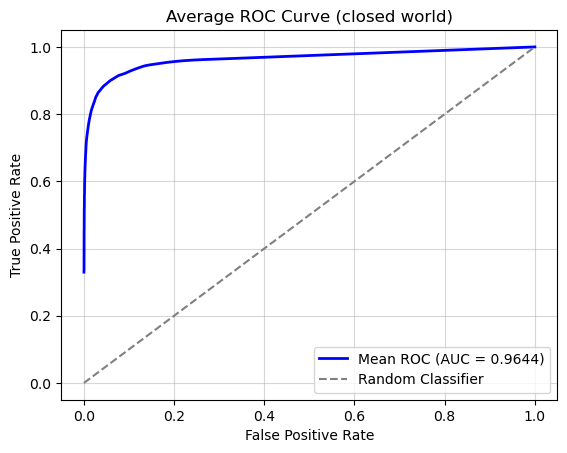

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 교차 검증 점수 계산
cv_scores = cross_val_score(best_model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# ROC Curve와 AUC 계산
y_pred_prob = best_model.predict_proba(X_test)  

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 평균 ROC Curve 계산
all_fpr = np.unique(np.concatenate([fpr[i] for i in fpr]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(len(fpr)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= len(fpr)
mean_auc = auc(all_fpr, mean_tpr)

# ROC Curve 시각화 
plt.figure()
plt.plot(all_fpr, mean_tpr, color='blue', lw=2, label=f"Mean ROC (AUC = {mean_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve (closed world)")
plt.legend(loc="lower right")
plt.grid(alpha=0.5)  
plt.show()